# Lab 11 Introduction to Decision Trees

- Dat_SF_18

## Before we begin:


**Installing Graphviz (optional):**
* Mac:
    * [Download and install PKG file](http://www.graphviz.org/Download_macos.php)
* Windows:
    * [Download and install MSI file](http://www.graphviz.org/Download_windows.php)
    * Add it to your Path: Go to Control Panel, System, Advanced System Settings, Environment Variables. Under system variables, edit "Path" to include the path to the "bin" folder, such as: `C:\Program Files (x86)\Graphviz2.38\bin`
__________

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

||continuous|categorical|
|---|---|---|
|**supervised**|**regression**|**classification**|
|**unsupervised**|dimension reduction|clustering|

## Objectives

* Identify various methods of measuring purity
* Learn how trees are build for both regressions and classification
* Use the ROC curve to understand the depth of classification error

### Exercise 1: Building a regression tree by hand

How do you build a decision tree? You're going to find out by building one in pairs!

Your training data is a tiny dataset of [used vehicle sale prices](https://raw.githubusercontent.com/justmarkham/DAT4/master/data/used_vehicles.csv). Your goal is to predict Price for out-of-sample data. Here are your instructions:

- Read the data into Pandas.
- Explore the data by sorting, plotting, or split-apply-combine (aka `group_by`).
- Decide which feature is the most important predictor, and use that to make your first split. (Only binary splits are allowed!)
- After making your first split, you should actually split your data in Pandas into two parts, and then explore each part to figure out what other splits to make.
- Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting. (As always, your goal is to build a model that generalizes well!)
- You are allowed to split on the same variable multiple times!
- Draw your tree, making sure to label your leaves with the mean Price for the observations in that "bucket".
- When you're finished, review your tree to make sure nothing is backwards. (Remember: follow the left branch if the rule is true, and follow the right branch if the rule is false.)

In [14]:
# import pandas
import pandas as pd

# read in vehicle data
vehicles = pd.read_csv('../data/used_vehicles.csv')

In [15]:
vehicles

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car
5,4000,2006,124000,2,car
6,3000,2004,177000,4,car
7,2000,2004,209000,4,truck
8,3000,2003,138000,2,car
9,1900,2003,160000,4,car


In [16]:
hundred_k_plus = vehicles[vehicles.miles >= 100000]
under_hunderd_k = vehicles[vehicles.miles < 100000]

In [19]:
under_hunderd_k

,price,year,miles,doors,type
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car
11,5000,2001,62000,4,car


In [20]:
not_new = under_hunderd_k[under_hunderd_k.year < 2010]
newish = under_hunderd_k[under_hunderd_k.year >= 2010]

#### How does a computer build a regression tree?

The ideal approach would be for the computer to consider every possible partition of the feature space. However, this is computationally infeasible, so instead an approach is used called **recursive binary splitting:**

- Begin at the top of the tree.
- For every single predictor, examine every possible cutpoint, and choose the predictor and cutpoint such that the resulting tree has the **lowest possible mean squared error (MSE)**. Make that split.
- Repeat the examination for the two resulting regions, and again make a single split (in one of the regions) to minimize the MSE.
- Keep repeating this process until a stopping criteria is met.

**How does it know when to stop?**

1. We could define a stopping criterion, such as a **maximum depth** of the tree or the **minimum number of samples in the leaf**.
2. We could grow the tree deep, and then "prune" it back using a method such as "cost complexity pruning" (aka "weakest link pruning").

Method 2 involves setting a tuning parameter that penalizes the tree for having too many leaves. As the parameter is increased, branches automatically get pruned from the tree, resulting in smaller and smaller trees. The tuning parameter can be selected through cross-validation.

Note: **Method 2 is not currently supported by scikit-learn**, and so we will use Method 1 instead.


### Building a regression tree in scikit-learn

In [21]:
# import pandas
import pandas as pd

# read in vehicle data
vehicles = pd.read_csv('../data/used_vehicles.csv')

# print out data
# vehicles

In [22]:
# dummies = pd.get_dummies(vehicles.type)
# vehicles.join(dummies.iloc[:,1])

In [23]:
# convert car to 0 and truck to 1
vehicles['type'] = vehicles.type.map({'car':0, 'truck':1})

In [24]:
# select feature columns (every column except for the 0th column)
feature_cols = vehicles.columns[1:]


# define X (features) and y (response)
X = vehicles[feature_cols]
y = vehicles.price

In [25]:
# split into train/test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [26]:
# print out each of the arrays
print X_train
print y_train
print X_test
print y_test

    year   miles  doors  type
10  2003  190000      2     1
4   2007   47000      4     0
1   2010   30000      2     0
12  1999  163000      2     1
0   2012   13000      2     0
13  1997  138000      4     0
9   2003  160000      4     0
8   2003  138000      2     0
11  2001   62000      4     0
5   2006  124000      2     0
10     2500
4      9000
1     14000
12     1800
0     22000
13     1300
9      1900
8      3000
11     5000
5      4000
Name: price, dtype: int64
   year   miles  doors  type
3  2009   78000      4     0
7  2004  209000      4     1
6  2004  177000      4     0
2  2010   73500      4     0
3     9500
7     2000
6     3000
2    13000
Name: price, dtype: int64


In [27]:
# import class, instantiate estimator, fit with training set
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [28]:
# make predictions
preds = treereg.predict(X_test)

In [29]:
# print predictions and actual values
print preds
print y_test

[ 5000.  1900.  1900.  5000.]
3     9500
7     2000
6     3000
2    13000
Name: price, dtype: int64


In [30]:
# print RMSE
from sklearn import metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(y_test, preds))

4622.4993239588475

### `cross_val_score`

`cross_val_score` is a function in sklearn that allows us to generate cross validation scores more programatically.


With `cross_val_score`, we can assume a k fold given X and y, and pass in a string for scoring.  
This should completely simplify our process:

```python
scores = cross_val_score(treereg, X, y, cv=3, scoring='accuracy_score')
```

the scoring string should match any function from the [metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module:

```python
['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'precision', 'r2', 'recall', 'roc_auc']
```

In [31]:
# use cross-validation to find best max_depth
from sklearn.cross_validation import cross_val_score

In [32]:
cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')

array([ -1.12050000e+08,  -6.27200000e+06,  -1.06500000e+06])

In [33]:
import numpy as np
# try max_depth=2
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4804.3767888427128

In [34]:
# try max_depth=3
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4592.1554255755254

In [35]:
# try max_depth=4
treereg = DecisionTreeRegressor(max_depth=4, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4704.0052694797387

In [36]:
# max_depth=3 was best, so fit a tree using that parameter with ALL DATA
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

Likewise, we can solve (and plot) for this more programattically:

Best score: 4592.15542558
Best depth: 3


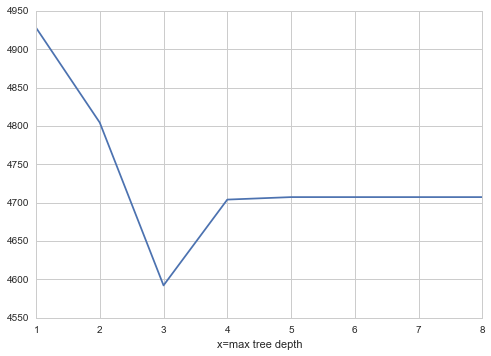

In [37]:
% matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

all_scores = []
best_score = -1
best_depth = 0
for i in range(1, 9):
    treereg = DecisionTreeRegressor(max_depth=i, random_state=1)
    scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
    current_score = np.mean(np.sqrt(-scores))
    # If the score mean is better than the current best, or best is the default (-1), then update!
    if current_score < best_score or best_score == -1:
        best_score = current_score
        best_depth = i
    # store to plot anyway!
    all_scores.append(current_score)
    
print "Best score: %s" % best_score
print "Best depth: %s" % best_depth

# now actually fit the model
treereg = DecisionTreeRegressor(max_depth=best_depth, random_state=1)
treereg.fit(X, y)

plt.figure()
plt.plot(range(1, 9), all_scores)
plt.xlabel('x=max tree depth')

In [38]:
treereg.feature_importances_

array([ 0.79874419,  0.20125581,  0.        ,  0.        ])

In [39]:
# compute the "Gini importance" of each feature: the (normalized) total reduction of MSE brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,type,0.000000


In [40]:
X_train

,year,miles,doors,type
10,2003,190000,2,1
4,2007,47000,4,0
1,2010,30000,2,0
12,1999,163000,2,1
0,2012,13000,2,0
13,1997,138000,4,0
9,2003,160000,4,0
8,2003,138000,2,0
11,2001,62000,4,0
5,2006,124000,2,0


In [41]:
# create a Graphviz file
from sklearn.tree import export_graphviz
with open("15_vehicles.dot", 'wb') as f:
    f = export_graphviz(treereg, out_file=f, feature_names=feature_cols)

# at the command line, run this to convert to PNG:
!dot -Tpng 15_vehicles.dot -o 15_vehicles.png

<img src="img/15_vehicles_instructor.png">

#### Interpreting a tree diagram

How do we read this decision tree?

**Internal nodes:**

- "samples" is the number of observations in that node before splitting
- "mse" is the mean squared error calculated by comparing the actual response values in that node against the mean response value in that node
- first line is the condition used to split that node (go left if true, go right if false)

**Leaves:**

- "samples" is the number of observations in that node
- "value" is the mean response value in that node
- "mse" is the mean squared error calculated by comparing the actual response values in that node against "value"

### Exercises: 


### Exercise 2: Use GridSearchCV to find te best Regression Tree

How do we know by pruning with max depth is the best model for us? Trees offer a variety of ways to pre-prune (that is, we tell a computer how to design the resulting tree with certain "gotchas").

Measure           | What it does
------------------|-------------
max_depth         | How many nodes deep can the decision tree go?
max_features      | Is there a cut off to the number of features to use?
max_leaf_nodes    | How many leaves can be generated per node?
min_samples_leaf  | How many samples need to be included at a leaf, at a minimum?  
min_samples_split | How many samples need to be included at a node, at a minimum?

While the data set is small, experiment with each in a loop and explain what is occuring.

In [42]:
#Your code here:

PARAMETERS = {'max_depth':[1,2,3,4,5,6], 'max_features':[1,2,3,4], 
              'max_leaf_nodes':[5,6,7,8,9,10], 'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[1,2,3,4]}
SCORING = 'mean_squared_error'

In [43]:
from sklearn import grid_search

#Grid Search
model = DecisionTreeRegressor()
clf = grid_search.GridSearchCV(model, PARAMETERS, scoring=SCORING, verbose=True, n_jobs=1)
clf.fit(X, y)

#After completion, show the final best results and scores
print clf.best_estimator_
print clf.best_score_
print np.sqrt(-clf.best_score_)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done 3199 tasks       | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done 4049 tasks       | elapsed:   14.8s
[Parallel(n_jobs=1)]: Done 4999 tasks       | elapsed:   18.2s
[Parallel(n_jobs=1)]: Done 6049 tasks       | elapsed:   22.2s
[Parallel(n_jobs=1)]: Done 6912 out of 6912 | elapsed:   25.5s finished


Fitting 3 folds for each of 2304 candidates, totalling 6912 fits
DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=3,
           max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
-34092857.1429
5838.90890003


### Execrise 3: Predicting for out-of-sample data

How accurate is scikit-learn's regression tree at predicting the out-of-sample data?

In [50]:
# read in out-of-sample data
oos = pd.read_csv('../data/used_vehicles_oos.csv')

# convert car to 0 and truck to 1
oos.type = oos.type.map({'car':0,'truck':1})


In [51]:
# define X and y
feature_cols = vehicles.columns[1:]
X_oos = oos[feature_cols]
y_oos = oos.price

X_oos

,year,miles,doors,type
0,2003,130000,4,1
1,2005,82500,4,0
2,2010,60000,2,0


In [52]:
# make predictions on out-of-sample data, using the treereg from above
preds = treereg.predict(X_oos)

# print predictions and actual values
print "Predicted Values: {}".format(preds)
print "Actual Values:    {}".format(y_oos.values)

Predicted Values: [  4000.   5000.  13500.]
Actual Values:    [ 3000  6000 12000]


In [53]:
# print RMSE
np.sqrt(metrics.mean_squared_error(y_oos, preds))

1190.2380714238084

__________________________
### Classification trees

Classification trees are very similar to regression trees. Here is a quick comparison:

|regression trees|classification trees|
|---|---|
|predict a continuous response|predict a categorical response|
|predict using mean response of each leaf|predict using most commonly occuring class of each leaf|
|splits are chosen to minimize MSE|splits are chosen to minimize a different criterion (discussed below)|

Note that classification trees easily handle **more than two response classes**! (How have other classification models we've seen handled this scenario?)

Here's an **example of a classification tree**, which predicts whether or not a patient who presented with chest pain has heart disease:

### Building a classification tree in scikit-learn

We'll build a classification tree using the [Titanic data](https://www.kaggle.com/c/titanic-gettingStarted/data) provided by Kaggle.

Note: this is the same data we used for the Midterm!

In [54]:
# read in the data
titanic = pd.read_csv('../data/titanic.csv')
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


In [55]:
# look for missing values
titanic.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

Let's choose our response and a few features, and decide whether we need to adjust them:

- **survived:** This is our response, and is already encoded as 0=died and 1=survived.
- **pclass:** These are the passenger class categories (1=first class, 2=second class, 3=third class). Should we consider these ordered or nonordered?
- **sex:** This is a binary category, so we should encode as 0=female and 1=male.
- **age:** We need to fill in the missing values.
- **embarked:** This is the port they emarked from. There are three unordered categories, so we'll create dummy variables.

In [56]:
# copy
titanic_c = pd.DataFrame(titanic)

# encode sex feature
titanic_c['sex'] = titanic.sex.map({'female':0, 'male':1})

# fill in missing values for age - there are much more intelligent ways to handle this... but for today:
titanic_c.age.fillna(titanic.age.mean(), inplace=True)

# print the updated DataFrame
titanic_c.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C


In [57]:
# create three dummy variables using get_dummies
pd.get_dummies(titanic_c.embarked, prefix='embarked').head(10)

,embarked_C,embarked_Q,embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


In [58]:
# # create three dummy variables, drop the first dummy variable, and store this as a DataFrame
embarked_dummies = pd.get_dummies(titanic_c.embarked, prefix='embarked').iloc[:, 1:]

# # join the two dummy variable columns onto the original DataFrame
titanic_c = titanic_c.join(embarked_dummies)

# # print the updated DataFrame
titanic_c.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,embarked_Q,embarked_S
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S,0,1
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,0,1
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q,1,0
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S,0,1
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S,0,1
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S,0,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C,0,0


In [59]:
# create a list of feature columns
feature_cols = ['pclass', 'sex', 'age', 'embarked_Q', 'embarked_S']

# define X and y
X = titanic_c[feature_cols]
y = titanic_c.survived

In [60]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [61]:
# create a Graphviz file
with open("15_titanic.dot", 'wb') as f:
    f = export_graphviz(treeclf, out_file=f, feature_names=feature_cols)
    
#from the command line run: 
#dot -Tpng 15_titanic.dot -o 15_titanic.png

<img src="img/15_titanic_instructor.png">

Notice the split in the bottom right, which was made only to increase node purity.

In [62]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,pclass,0.242664
1,sex,0.655584
2,age,0.064494
3,embarked_Q,0.000000
4,embarked_S,0.037258


In [63]:
# Compute the confusion matrix
from sklearn import metrics
conf = metrics.confusion_matrix(y, treeclf.predict(X))
print conf

[[524  25]
 [133 209]]


### More on Confusion Matrices (one last metric for classification)

Arguably the most useful metric we can use in binary classification problems is the Recieving Opererating Characteristic (ROC) curve, or in particular, the Area Under said Curve (AUC). We can calculate the AUC from the results of a confusion matrix:

<img src='img/confusion_matrix_metrics.png'>

In [64]:
## THE CONFUSION MATRIX FROM SKLEARN IS INVERTED. (rows = true, cols = predicted)
from __future__ import division
def true_confusion_matrix(mtrx):
    return np.array([[mtrx[1, 1], mtrx[0, 1]], [mtrx[1, 0], mtrx[0, 0]]])

true_conf = true_confusion_matrix(conf)

print true_conf
# false positive rate (fpr) = false positives / (false positives + true negatives)
# "What percent of the negatives were predicted as positive?"
# Goal: keep this low
def fpr(confusion):
    return confusion[0, 1] / (confusion[0, 1] + confusion[1, 1])

print 'fpr', fpr(true_conf)

# true positive rate/recall (tpr) = true positives / (true positives + false negatives)
# "What percent of the positives were accurately measured as positives?"
# Goal: keep this high
def tpr(confusion):
    return confusion[0, 0] / (confusion[0, 0] + confusion[1, 0])

print 'tpr', tpr(true_conf)


# precision = true positives / (true positives + false positives)
# "What percent of predicted positives were truly positive?
# Goal: keep this high
def precision(confusion):
    return confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])

print 'precision', precision(true_conf)
    
# accuracy = (true positives + true negatives) / total observations
# "What percent of values were accurately predicted?"
# Goal: Keep this high
def acc(confusion):
    return (confusion[0, 0] + confusion[1, 1]) / (confusion[0, 0] + confusion[1, 1] + confusion[0, 1] + confusion[1, 0])

print 'accuracy', acc(true_conf)
    
# auc = calculate area under x=fpr, y=tpr

[[209  25]
 [133 524]]
fpr 0.0455373406193
tpr 0.611111111111
precision 0.893162393162
accuracy 0.822671156004


fpr 0.0455373406193
tpr 0.611111111111
precision 0.893162393162
accuracy 0.822671156004


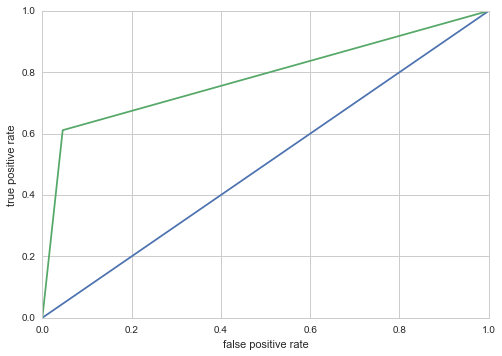

In [65]:
# sklearn has all of this built in:

print 'fpr', metrics.roc_curve(y, treeclf.predict(X))[0][1] #fpr
print 'tpr', metrics.roc_curve(y, treeclf.predict(X))[1][1] #tpr
print 'precision', metrics.precision_score(y, treeclf.predict(X))
print 'accuracy', metrics.accuracy_score(y, treeclf.predict(X))

roc = metrics.roc_curve(y, treeclf.predict(X))
plt.figure()
# dummy, what's the worst random job we can do?
plt.plot([0, 0.5, 1], [0, 0.5, 1])
plt.plot(roc[0], roc[1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

### Independent / On your Own

Like we had done early optimizing the model, here are a few things we should try to make sure we've fit our best model:

1. Play with the stopping criteria in a loop and determine which produces the best cross validated model.
2. Compare your best tree model to another classifier (naive bayes, logistic regression). Which seems to perform the best, and why do you think so?

### Wrapping up decision trees

Here are some advantages and disadvantages of decision trees that we haven't yet talked about:

**Advantages:**

- Can be specified as a series of rules, and are thought to more closely approximate human decision-making than other models
- Non-parametric (will do better than linear regression if relationship between predictors and response is highly non-linear)

**Disadvantages:**

- Small variations in the data can result in a completely different tree
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
- Can create biased trees if the classes are highly imbalanced

Note that there is not just one decision tree algorithm; instead, there are many variations. A few common decision tree algorithms that are often referred to by name are C4.5, C5.0, and CART. (More details are available in the [scikit-learn documentation](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart).) scikit-learn uses an "optimized version" of CART.

## Resources

**Decision Trees**

- scikit-learn documentation: [Decision Trees](http://scikit-learn.org/stable/modules/tree.html)
- Additional thoughts on [Gini Vs Entropy](http://www.garysieling.com/blog/sklearn-gini-vs-entropy-criteria)

** ROC **
- [Really Awesome Paper!](https://ccrma.stanford.edu/workshops/mir2009/references/ROCintro.pdf)



